In [111]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats as scs
import timeit

<!-- Tasks (FILIP)

#- Put into Notebook format
- Copy text from latex into notebook
- Discuss runtimes of different methods
- Insert (3) and (4). -->

<h1> Exercise 2: Discrete random variables

<h3> (1) Geometric distributions

For sampling values from the geometric distribution, a function is defined. The function is used to sample 10000 values, for three different values of p. The histogrammes are compared below.

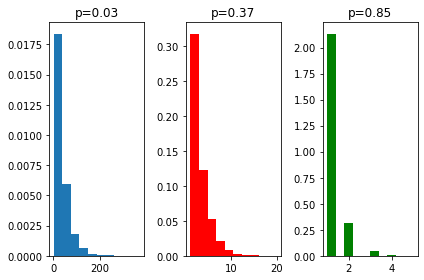

In [112]:
def geom(p,N):
    U = np.random.random(N)
    return np.floor(np.log(U)/np.log(1-p)) + 1
p1,p2,p3=0.03,0.37,0.85
gm1,gm2,gm3 = geom(p1,10000),geom(p2,10000),geom(p3,10000)

#Histograms
plt.figure()
plt.subplot(1, 3, 1)
plt.hist(gm1,density=True)
plt.title("p=0.03")

plt.subplot(1, 3, 2)
plt.hist(gm2,density=True,color='red')
plt.title("p=0.37")
plt.subplot(1, 3, 3)
plt.hist(gm3,density=True,color='green')
plt.title("p=0.85")
plt.tight_layout()


The histogrammes clearly show geometric distributions with different shapes.

<h3> (2) 6-point distribution

We can simulate the given 6-point distribution using the three methods; ’the crude method',
the 'rejection method' and the 'alias method'.
In all the methods, uniformly distributed random numbers are generated and used to sample
from the desired distribution. The implementations are made in a way such that a list of uniform random numbers are already available (for testing purposes) - this is true except for when the rejection method has rejected a value.

In [113]:
n = 1000000
np.random.seed(12346) #set random seed
randoms = np.random.uniform(size=(n,2))

<h4> (2a) The Crude Method

The direct method makes use of the CDF, of the given distribution - note that the function is discrete. A uniform random number is generated. The random number will land in one of the probability intervals (on the CDF) for each outcome. When the random number lands within this interval, the corresponding outcome is chosen. 

In [114]:
p = np.array([7/48,5/48,1/8,1/16,1/4,5/16])
pa = np.cumsum(p)

def ncrude(nn):
    ss = np.zeros(nn)
    #U = np.random.uniform(size=nn)
    Uc = randoms[0:nn,0].copy()
    for j in range(nn):
        for i in range(6):
            if Uc[j] < pa[i]:
                ss[j] = i+1
                break
    return ss

<h4> (2b) The Rejection Method

The rejection method works differently. It generates two uniform random numbers, whereof one of them is used to generate a potential number from the distribution (1-6), while the other is used to simulate the probability of that outcome being accepted/rejected. 

In [115]:
k = 6
q = 1/k
c = max(p)/q
def nrejection(nn):
    ss = np.zeros(nn)
    Ur = randoms[0:nn,:].copy()#np.random.uniform(size=[nn,2])
    #U1 = np.random.uniform(size=nn)
    #U2 = np.random.random(nn)
    for j in range(nn):
        while(ss[j]==0):
            Y = int(k*Ur[j,0])+1
            if Ur[j,1] <= p[Y-1]/(c*q):
                ss[j] = Y
                break
            else:
                Ur[j,0],Ur[j,1] = np.random.uniform(size=2)
    return ss

<h4> The Alias Method

For the alias method, a set of auxillary tables has to be set up. Like in the rejection method, two uniform random numbers are generated. However, unlike the rejection method, a set of numbers cannot be fully rejected - but are used for choosing an outcome. The method is implemented below.

In [116]:
#Setup for alias using pseudo-code from slides
L=np.ones(k)*range(k)
F=k*p
G = np.where(F>=1)[0]
S = np.where(F<=1)[0]
while np.size(S)>0:
    i = G[0]
    j = S[0]
    L[j] = i+1
    F[i] = F[i] - (1 - F[j])
    
    if F[i] < 1-0.000001:
        G = np.delete(G,0)
        S = np.append(S,i)
    S = np.delete(S,0)

#The alias method
def nalias(nn):
    ss = np.zeros(nn)
    UA = randoms[0:nn,:].copy()
    for j in range(nn):
        I = (np.floor(k*UA[j,0]) + 1).astype(int)
        if UA[j,1] <= F[I-1]:
            ss[j] = I
        else:
            ss[j] = L[I-1]
    return ss

<h3> (3) Comparison of the methods

The three methods' precision and efficiency can be compared. Histograms and runtimes are examined.

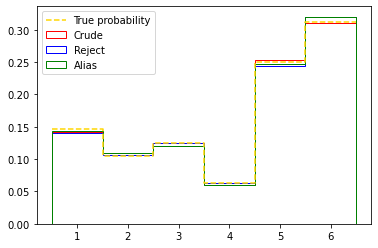

In [117]:
N_samples = 10000
p = np.array([7/48,5/48,1/8,1/16,1/4,5/16])
pp = p.tolist()
pp.append(p[-1])
plt.hist(ncrude(N_samples),bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5],density=1,rwidth=1,edgecolor='red',color='red',alpha=1,histtype='step',label="Crude")
plt.hist(nrejection(N_samples),bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5],density=1,rwidth=1,edgecolor='blue',color='blue',alpha=1,histtype='step',label="Reject")
plt.hist(nalias(N_samples),bins=[0.5,1.5,2.5,3.5,4.5,5.5,6.5],density=1,rwidth=1,edgecolor='green',color='green',alpha=1,histtype='step',label="Alias")
plt.step([0.5,1.5,2.5,3.5,4.5,5.5,6.5],pp,'--',where="post",color="gold",label="True probability")

plt.legend()

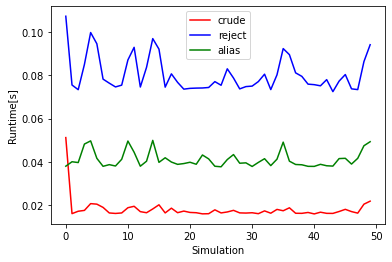

In [118]:
N_samples = 10000
sims = 50

sC = np.zeros(sims)
sR = np.zeros(sims)
sA = np.zeros(sims)

for s in range(sims):   
    #efficient list methods
    startC = timeit.default_timer()
    ncrude(N_samples)
    stopC = timeit.default_timer()
    
    startR = timeit.default_timer()
    nrejection(N_samples)
    stopR = timeit.default_timer()
    
    startA = timeit.default_timer()
    nalias(N_samples)
    stopA = timeit.default_timer()
    sC[s] = (stopC-startC)
    sR[s] = (stopR-startR)
    sA[s] = (stopA-startA)

plt.plot(sC,color="red",label="crude")
plt.plot(sR,color="blue",label="reject")
plt.plot(sA,color="green",label="alias")
plt.xlabel("Simulation")
plt.ylabel("Runtime[s]")
plt.legend()

It can be observed that the histogrammes are very similar. The runtime of the rejection method is the highest, while the lowest is for the crude method.

<h3> (4) Recommendations

It could be observed that the precision of the methods are sufficient, which means that the best suited method is a question of efficiency. In the test of the runtime it could be seen that the crude method was the fastest - however this is only true for the sampled distribution. The methods each have their own strengths and weaknesses. 

The crude method is very efficient and easy to implement. However, if there was a high number of outcomes (and not just 6) the number of comparisons could easily increase the runtime drastically. Additionally, the method is reliant on the CDF being computed, which could be hard in some special cases. 

The rejection method is probably the easiest method to apply on any given distribution, however, as it could be seen in the runtime-test, it is the slowest of these methods. It could be especially inefficient if a lot of the candidate numbers are rejected.

The alias method is efficient even over a large nmber of samples and outcomes, however it can be difficult to implement, and takes initial time and memory to simply do the setup.
